# <font color='red'> Project 1  
 
    
#  Regression

# About the Data

Date: time (yr:mon:day:hr:min:sec)       Appliances: energy use in Wh     lights: Energy use of light fixtures in the house(Wh)  
T1: Temperature in kitchen area(C)                                          RH_1: Humidity in kitchen area(%)      
T2: Temperature in living room area(C)                                      RH_2: Humidity in living room(%)         
T3: Temperature in laundry room                                             RH_3: Humidity in laundry room area(%)             
T4: Temperature in office room(C)                                           RH_4: Humidity in office room(%)       
T5: Temperature in bathroom in (C)                                          RH_5: Humidity in bathroom(%)                    
T6: Temperature outside the building (north side) in (C)                    RH_6: Humidity outside the building (northside)%    
T7: Temperature in ironing room in (C)                                      RH_7: Humidity in ironing room in (%)    
T8:Temperature in teenager room 2 in (C)                                    RH_8: Humidity in teenager room 2 in (%) 

T9: Temperature in parents room in (C)                                      RH_9: Humidity in parents room in %

To: Temperature outside (from Chievres weather station) in (C)              Pressure (from Chievres weather station): in mm Hg
RH_out: Humidity outside (from Chievres weather station) in (%)             Wind speed (from Chievres weather station): in(m/s)
Visibility (from Chievres weather station): Ordinal data                    Tdewpoint (from Chievres weather station): Cat data
rv1: Random variable 1(nondimensional)                                      rav2: Random variable 2(nondimensional)

Where indicated, hourly data (then interpolated) from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis, rp5.ru. Permission was obtained from Reliable Prognosis for the distribution of the 4.5 months of weather data.

In [ ]:
###Downloading all the library required for the project
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics
import missingno as mno #install running pip install missingno on cmd if using PYPI directly or conda install -c conda-forge missingno -if using anaconda)\
from missingpy import KNNImputer # pip install missingpy on cmd 
import plotly.offline as py #Package for data visulization
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from  sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from  sklearn.preprocessing  import PolynomialFeatures
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Exploratory Data Analysis

In [ ]:
#Import data into python
data = pd.read_csv(r'C:\Users\nayak\Downloads\ML Project1\KAG_energydata_data.csv', index_col= None)

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
#Function to convert categorical data to label encoding(We are not using Onehot encoders as the variable is ordinal)
def conditions(df):
    if (df['Tdewpoint']== 'LDT'):
        return 0
    elif (df['Tdewpoint']== 'ADT'):
        return 1
    elif (df['Tdewpoint']== 'NDT'):
        return 2
    else:
        return 3    

data['Tdewpoint']= data.apply(conditions, axis=1)

# Missing data visualization

In [ ]:
pd.DataFrame(data.isna().sum(), columns=["records missing"]).T

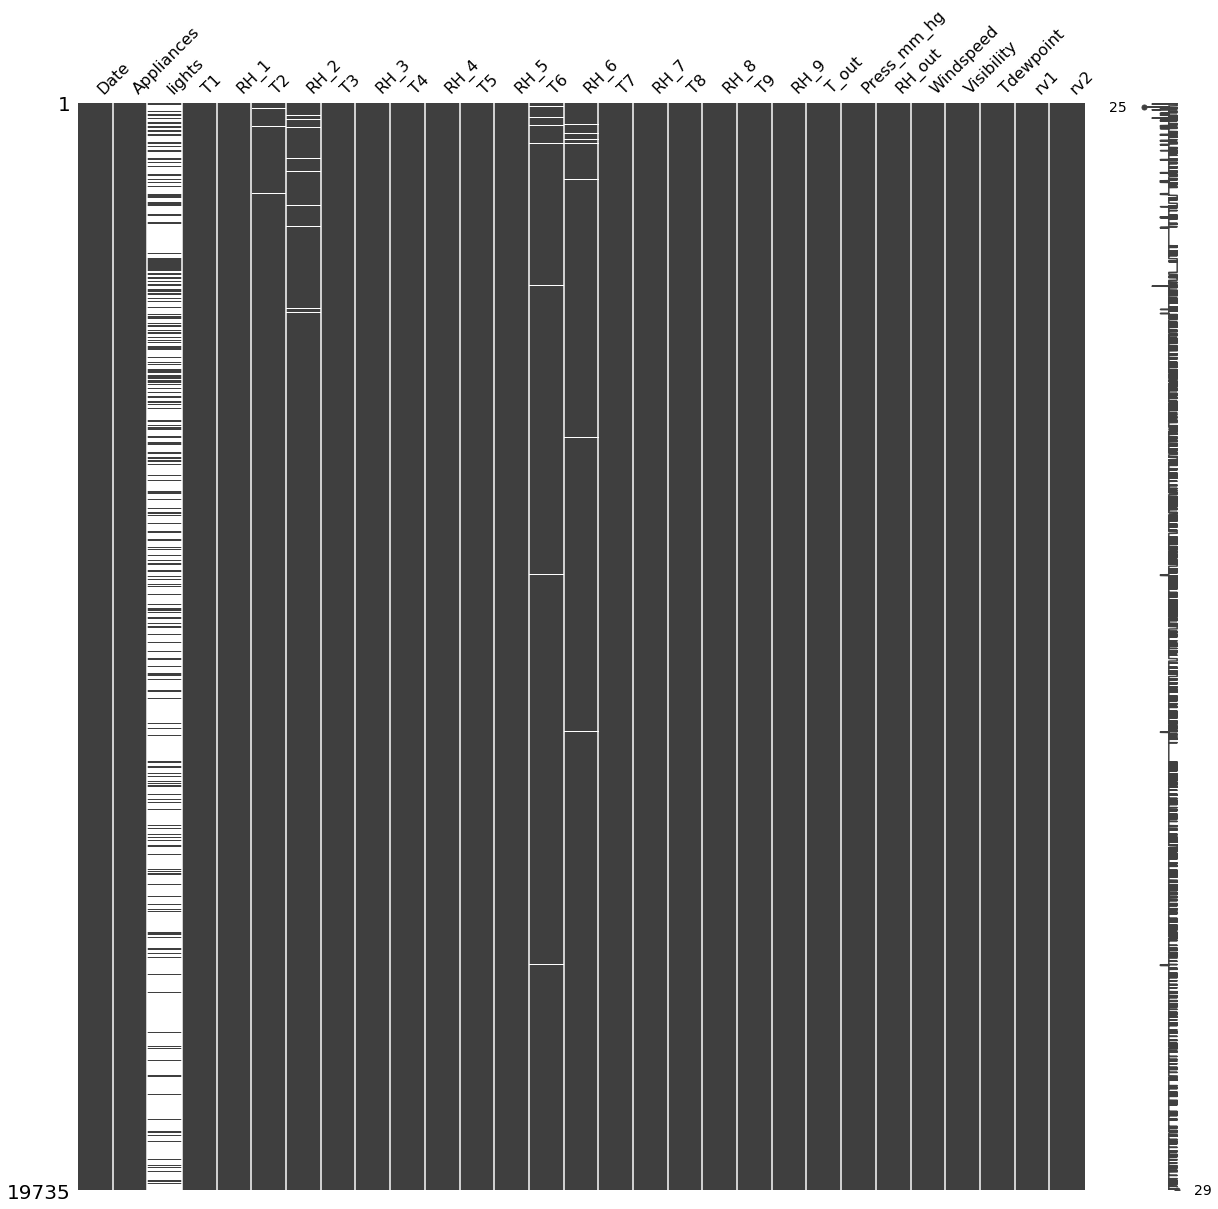

In [7]:
mno.matrix(data, figsize = (20, 20))

In [8]:
data= data.drop('lights', axis=1)

In [9]:
data= data.drop('Date', axis=1)

Date dropping reason: As we are not trying to analyze the problem as Time Series rather regress on "Appliance" column.

# Imputation using Missingpy package!!

In [10]:
imputer = KNNImputer(missing_values="NaN", n_neighbors=5, weights="uniform",
                     metric="masked_euclidean",)
data_new = imputer.fit_transform(data)

In [11]:
data_new= pd.DataFrame(data_new)
data_new.columns= data.columns

In [12]:
pd.DataFrame(data_new.isna().sum(), columns=["records missing"]).T

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
records missing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


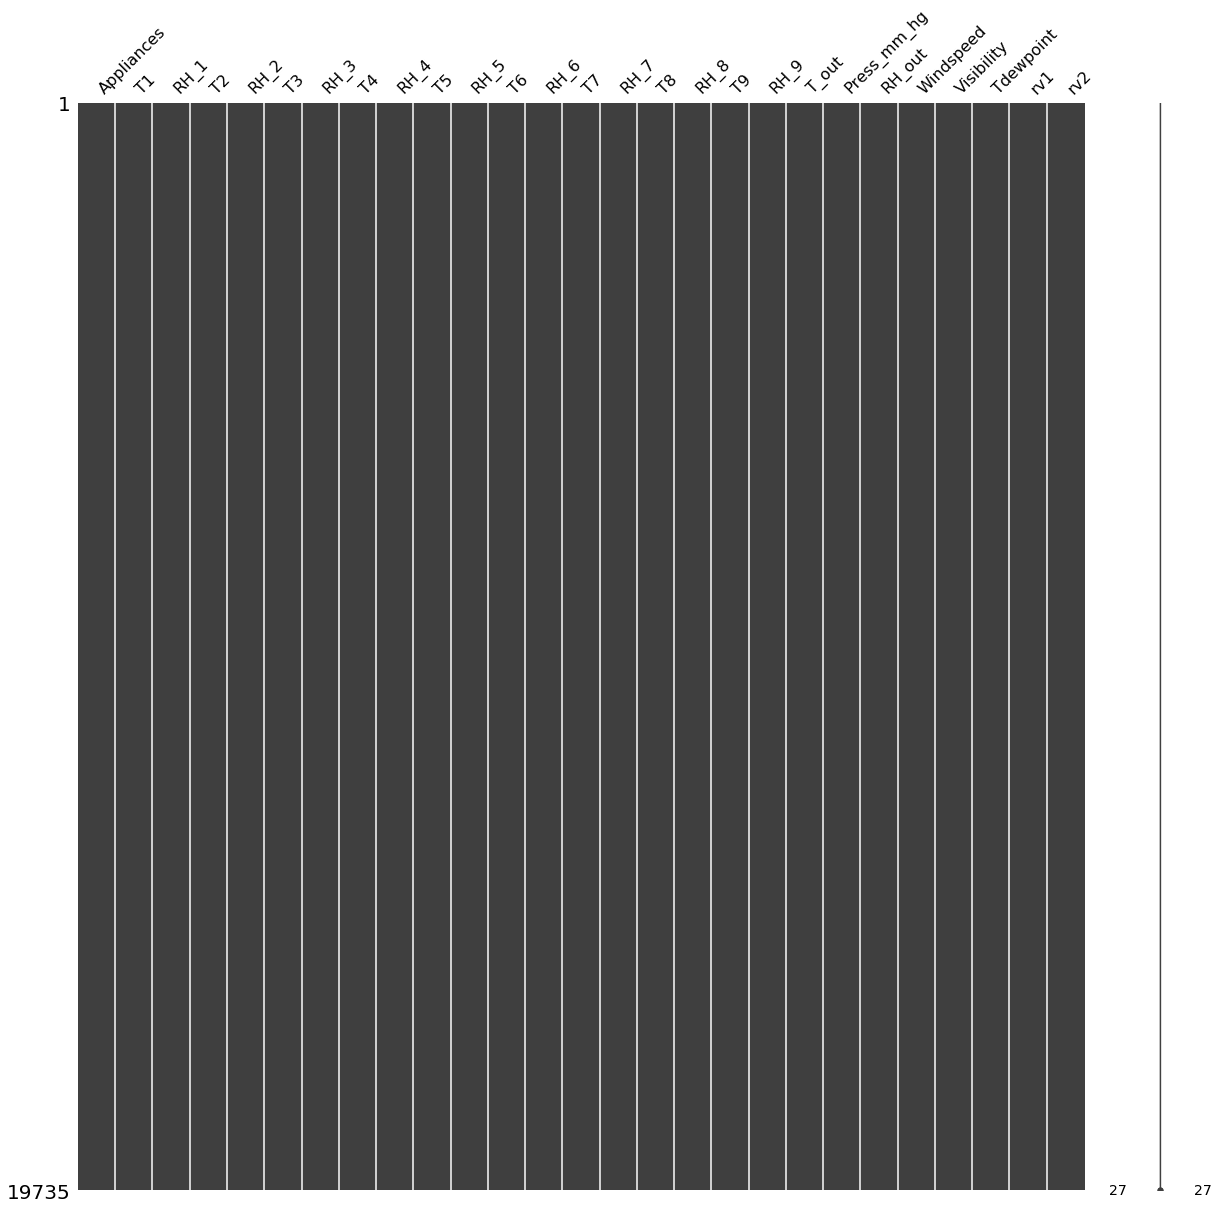

In [13]:
mno.matrix(data_new, figsize = (20, 20))

We can see all the missing data has been replaced with Imputed data!!

# Data Visualization

In [14]:
## Divide the columns based on type for clear column management 

col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg",
                "Windspeed","Visibility"] 

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [15]:
# Seperate dependent and independent variables 
feature_vars = data_new[col_temp + col_hum + col_weather + col_randoms] 
target_vars = data_new[col_target]

In [16]:
feature_vars.describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,...,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,21.686571,20.340843,22.267611,20.855335,19.592106,7.913793,20.267106,22.029107,19.485828,40.259739,...,42.936165,41.552401,7.411665,1.274284,79.750418,755.522602,4.039752,3.444388,24.988033,24.988033
std,1.606066,2.192666,2.006111,2.042884,1.844623,6.087680,2.109993,1.956162,2.014712,3.979299,...,5.224361,4.151497,5.317409,0.824842,14.901088,7.399441,2.451221,1.088715,14.496634,14.496634
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.065000,15.390000,16.306667,14.890000,27.023333,...,29.600000,29.166667,-5.000000,0.000000,24.000000,729.300000,0.000000,0.000000,0.005322,0.005322
25%,20.760000,18.790000,20.790000,19.530000,18.277500,3.626667,18.700000,20.790000,18.000000,37.333333,...,39.066667,38.500000,3.666667,1.000000,70.333333,750.933333,2.000000,2.000000,12.497889,12.497889
50%,21.600000,20.000000,22.100000,20.666667,19.390000,7.300000,20.033333,22.100000,19.390000,39.656667,...,42.375000,40.900000,6.916667,1.000000,83.666667,756.100000,3.666667,4.000000,24.897653,24.897653
75%,22.600000,21.500000,23.290000,22.100000,20.619643,11.256000,21.600000,23.390000,20.600000,43.066667,...,46.536000,44.338095,10.408333,2.000000,91.666667,760.933333,5.500000,4.000000,37.583769,37.583769
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,26.000000,27.230000,24.500000,63.360000,...,58.780000,53.326667,26.100000,3.000000,100.000000,772.300000,14.000000,5.000000,49.996530,49.996530


In [17]:
target_vars.describe()

,Appliances
count,19735.000000
mean,97.694958
std,102.524891
min,10.000000
25%,50.000000
50%,60.000000
75%,100.000000
max,1080.000000


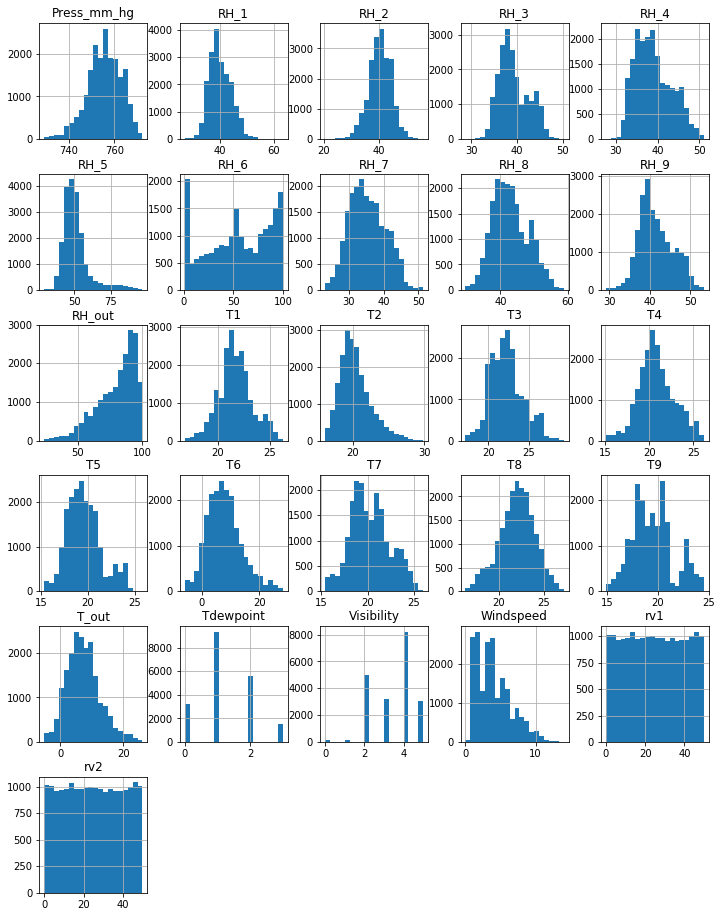

In [18]:
# Histogram of all the features to understand the distribution
feature_vars.hist(bins = 20 , figsize= (12,16)) ;

Focussed displots for RH_6 , RH_out , Visibility , Windspeed due to irregular distribution.

Using Plotly helps us visualize data better as it allows us to interact with the plot like zoom in to the distribution and hover around to locate the values corresponding to axis value

In [19]:
hist_data= [(feature_vars['RH_6']).values, (feature_vars['RH_out']).values]
group_labels= ['RH_6','RH_out']
fig= ff.create_distplot(hist_data, group_labels)
py.plot(fig)
#iplot(fig) #Prints the interactive plot in Jupyter notebook
hist_data1= [(feature_vars['Visibility']).values, (feature_vars['Windspeed']).values]
group_labels1= ['Visibility','Windspeed']
fig1= ff.create_distplot(hist_data1, group_labels1)
py.plot(fig1)
#iplot(fig1) #Prints the interactive plot in Jupyter notebook

'temp-plot.html'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205D8667A20>]],
      dtype=object)

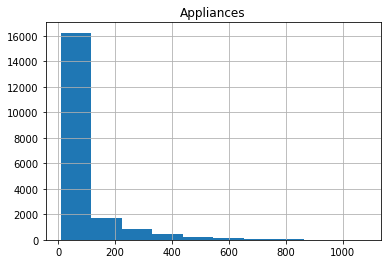

In [20]:
#Distribution of values in Applainces column
target_vars.hist()

# Observations:

1. Almost all Temperature variable follows "Normal Distribution".
2. Almost all Humidity variable follows "Normal Distribution" except RH_Out and RH_6, may be because they were placed outside      the house
3. RH_6 has a quite substatial values in bin[1-1.990] which could be rading from summer months(april/may) of data(Jan-June)
4. Windspeed column is postively skewed & RH_out is negatively skewed
5. RH_out, Windspeed & Visibility contains outliers
6. Appliance column is postively skewed with most of the values around mean 100 Wh

# Data Preprocessing 

 Data Scaling: Using Standard Scaler for scaling as some of the columns contains outliers and min_max are very sensitive to outiers

In [21]:
# I took a sbupart of the data for analysis as it was giving memory error and was very slow for such large dataset
x= feature_vars.iloc[:1200,:]
y= target_vars.iloc[:1200,:]

scaler= StandardScaler()
x=scaler.fit_transform(x)

In [22]:
x_train, x_test, y_train, y_test= train_test_split(x,y, random_state=0)

In [23]:
compiled= pd.DataFrame(columns= ['Regressor', 'Avg_Train_Score', 'Avg_Test_Score', 'RMSE_Best_Param', 'Best_Hyperparameters'])

# Model Implemented

We will be looking at following Algorithms

Linear regression model

Improved Linear regression models
1. Ridge regression
2. Lasso regression
3. Poynomial regression


Logistic regression

Support vector regression
1. Simple
2. rbf
3. Poly
4. Linear

K Nearest NeighborsRegressor

Decision Tree regressor

# Model Evaluation Technique
K-fold Cross Validation: For following reason
1. As the data set in consideration is not small, computation time will be higher in LOOC.
2. Reduced Bias
3. Variance of resulting estimate can be reduced by increasing K value

# Model Evaluation Metrics
Used Train, Test score and RMSEvto find the best parameters for Grid_Search and then select the best model out of them.

# Linear Regression model

In [24]:
lreg= LinearRegression()
lreg.fit(x_train, y_train)
print(f'Train score for Linear regression model without using Kfold validation is: {lreg.score(x_train, y_train)}')

train_scores= cross_val_score(lreg,x_train,y_train, cv=10)
print(f'Train score for Linear regression model using 10Fold cross validation is:  {train_scores.mean()}')
test_scores= cross_val_score(lreg,x_test,y_test, cv=10)
print(f'Test score for Linear regression model using 10Fold cross validation is:  {test_scores.mean()}')

Train score for Linear regression model without using Kfold validation is: 0.22314897240155618
Train score for Linear regression model using 10Fold cross validation is:  0.13645371693622851
Test score for Linear regression model using 10Fold cross validation is:  0.025437005586257565


In [25]:
mse= cross_val_score(lreg, x_train, y_train, scoring="neg_mean_squared_error", cv=10)
print(f'RMSE for Linear regression model using 10Fold cross validation is: {mse.mean()}')

RMSE for Linear regression model using 10Fold cross validation is: -14773.423567754042


In [26]:
compiled=compiled.append({'Regressor': 'LinearRegression', 'Avg_Train_Score': train_scores.mean(), 
                          'Avg_Test_Score': test_scores.mean(), 'RMSE_Best_Param': mse.mean(), 
                          'Best_Hyperparameters': "N/A"}, ignore_index=True)

# Improved Linear Regression

# 1. Ridge 

In [27]:
ridge= Ridge()
param= {'alpha':[ 0.01, 0.1, 1, 5, 10,20,30,50]}
ridge_regressor= GridSearchCV(ridge, param, cv=10, return_train_score= True)
ridge_regressor.fit(x_train, y_train)
ridge_regressor.score(x_test, y_test)

0.14852490072470514

In [28]:
ridge_train_score_list= ridge_regressor.cv_results_["mean_train_score"]
print(f'Train score across different alpha is: {ridge_train_score_list}')

ridge_test_score_list= ridge_regressor.cv_results_["mean_test_score"]
print(f'\nTest score across different alpha is: {ridge_test_score_list}')

Train score across different alpha is: [0.22672228 0.22672026 0.22655061 0.22425457 0.22043074 0.21260872
 0.20529193 0.19251691]

Test score across different alpha is: [0.13648128 0.13672507 0.13880236 0.14373568 0.14596519 0.14611843
 0.14410056 0.13821864]


Best parameter for ridge regression is: {'alpha': 20}
Average training score for ridge regression model using 10Fold CV is: 0.2168870024327188
Average testing score for ridge regression model using 10Fold CV is: 0.14126840141745886


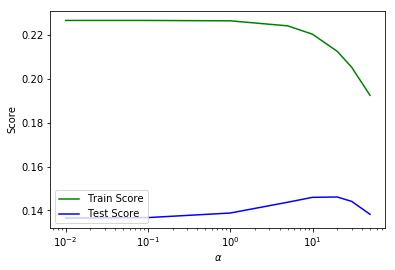

In [29]:
#visualize the result:plots
x_range= [0.01, 0.1, 1, 5, 10, 20, 30, 50]
plt.plot(x_range, ridge_train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, ridge_test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')

print(f'Best parameter for ridge regression is: {ridge_regressor.best_params_}')
print(f'Average training score for ridge regression model using 10Fold CV is: {((ridge_regressor.cv_results_["mean_train_score"]).sum())/len(x_range)}')
print(f'Average testing score for ridge regression model using 10Fold CV is: {((ridge_regressor.cv_results_["mean_test_score"]).sum())/len(x_range)}')
      

In [30]:
#Implementing the final model with the best param with Root mean squared error(RMSE) as the scoring metrics
ridge_final= Ridge(alpha=20)
ridge_final.fit(x_train, y_train)
ridge_final_train_scores= cross_val_score(ridge_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
ridge_final_test_scores= cross_val_score(ridge_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Ridge regression model using 10 Fold CV is: {ridge_final_train_scores.mean()}')
print(f'Test  RMSE for best Ridge regression model using 10 Fold CV is: {ridge_final_test_scores.mean()}')

Train RMSE for best Ridge regression model using 10 Fold CV is: -14662.966896770798
Test  RMSE for best Ridge regression model using 10 Fold CV is: -17989.59564547044


In [31]:
compiled=compiled.append({'Regressor': 'Ridge_Regression', 
                          'Avg_Train_Score': ((ridge_regressor.cv_results_["mean_train_score"]).sum())/len(x_range), 
                          'Avg_Test_Score': ((ridge_regressor.cv_results_["mean_test_score"]).sum())/len(x_range), 
                          'RMSE_Best_Param': ridge_final_test_scores.mean(),
                          'Best_Hyperparameters': ridge_regressor.best_params_}, ignore_index=True)

# 2. Lasso

In [32]:
#Lasso regression
lasso= Lasso()
param= {'alpha':[0.0001, 0.001, 0.01, 0.1, 1,5]}
lasso_regressor= GridSearchCV(lasso, param, cv=10, return_train_score= True)
lasso_regressor.fit(x_train, y_train)
lasso_regressor.score(x_test, y_test)

0.14694910542838957

In [33]:
lasso_test_score_list= lasso_regressor.cv_results_["mean_test_score"]
print(f'Train score across different alpha is: {lasso_test_score_list}')

lasso_train_score_list= lasso_regressor.cv_results_["mean_train_score"]
print(f'\nTest score across different alpha is: {lasso_train_score_list}')

Train score across different alpha is: [0.13645549 0.13647135 0.13662591 0.13776226 0.13609906 0.06983221]

Test score across different alpha is: [0.2267223  0.22672226 0.22671881 0.22637952 0.20597025 0.10856615]


Best parameter for Lasso regression is: {'alpha': 0.1}
Average training score for Lasso regression model using 10Fold CV is: 0.20351321513028922
Average testing score for Lasso regression model using 10Fold CV is: 0.1255410454244302


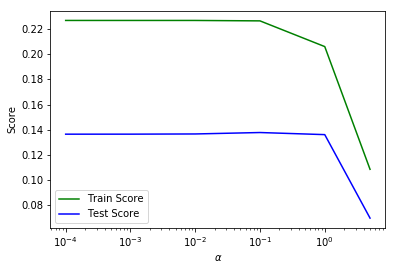

In [34]:
#visualize the result:plots
x_range= [0.0001, 0.001, 0.01, 0.1, 1,5]
plt.plot(x_range, lasso_train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, lasso_test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')


print(f'Best parameter for Lasso regression is: {lasso_regressor.best_params_}')
print(f'Average training score for Lasso regression model using 10Fold CV is: {((lasso_regressor.cv_results_["mean_train_score"]).sum())/len(x_range)}')
print(f'Average testing score for Lasso regression model using 10Fold CV is: {((lasso_regressor.cv_results_["mean_test_score"]).sum())/len(x_range)}')
      

In [35]:
#Implementing the final model with the best param with Root mean squared error(RMSE) as the scoring metrics
lasso_final= Lasso(alpha=0.1)
lasso_final.fit(x_train, y_train)
lasso_final_train_scores= cross_val_score(lasso_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
lasso_final_test_scores= cross_val_score(lasso_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Lasso regression model using 10 Fold CV is: {lasso_final_train_scores.mean()}')
print(f'Test  RMSE for best Lasso regression model using 10 Fold CV is: {lasso_final_test_scores.mean()}')

Train RMSE for best Lasso regression model using 10 Fold CV is: -14751.352578105802
Test  RMSE for best Lasso regression model using 10 Fold CV is: -18405.348432579565


In [36]:
compiled=compiled.append({'Regressor': 'Lasso_Regression',
                          'Avg_Train_Score': ((lasso_regressor.cv_results_["mean_train_score"]).sum())/len(x_range), 
                          'Avg_Test_Score': ((lasso_regressor.cv_results_["mean_test_score"]).sum())/len(x_range),
                          'RMSE_Best_Param': lasso_final_test_scores.mean(), 'Best_Hyperparameters': lasso_regressor.best_params_}, ignore_index=True)

# 3. Polynomial

In [37]:
lreg2= LinearRegression()
train_score_list = []
test_score_list = []

#Use maxiter as a param
for n in [1,2,3]:
    poly = PolynomialFeatures(n)
    X_train_poly = poly.fit_transform(x_train)
    lreg2.fit(X_train_poly, y_train)
    train_scores= cross_val_score(lreg2,X_train_poly,y_train, cv=10)
    test_scores= cross_val_score(lreg2,x_test,y_test, cv=10)
    train_score_list.append(train_scores)
    test_score_list.append(test_scores)

In [38]:
poly_train_score_list1=[]
poly_test_score_list1=[]

for i in [0,1,2]:
    poly_train_score_list= train_score_list[i].sum()/len(train_score_list[i])
    poly_train_score_list1.append(poly_train_score_list)
    poly_test_score_list= test_score_list[i].sum()/len(test_score_list[i])
    poly_test_score_list1.append(poly_test_score_list)
    

In [39]:
print('Best score comes from Degree 2')
print(f'Average Train score across different params is: {poly_train_score_list1}')    
print(f'Average Test score across different params is: {poly_test_score_list1}')    


Best score comes from Degree 2
Average Train score across different params is: [0.13645371693622854, -0.33548603998375015, -3.1859065071489825]
Average Test score across different params is: [0.025437005586257565, 0.025437005586257565, 0.025437005586257565]


Text(0,0.5,'Score')

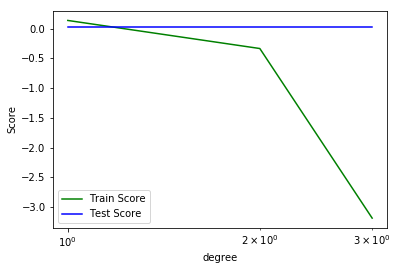

In [40]:
x_range= [1,2,3]
plt.plot(x_range, poly_train_score_list1, c = 'g', label = 'Train Score')
plt.plot(x_range, poly_test_score_list1, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'degree')
plt.ylabel('Score')

In [41]:
poly_final= PolynomialFeatures(degree=2)
x_train_poly_final= poly_final.fit_transform(x_train)
poly_final.fit(x_train_poly_final, y_train)
lreg2.fit(x_train_poly_final, y_train)

poly_final_train_scores= cross_val_score(lreg2, x_train_poly_final, y_train, cv=10, scoring= 'neg_mean_squared_error')
poly_final_test_scores= cross_val_score(lreg2, x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Poly regression model using 10 Fold CV is: {poly_final_train_scores.mean()}')
print(f'Test  RMSE for best Poly regression model using 10 Fold CV is: {poly_final_test_scores.mean()}')

Train RMSE for best Poly regression model using 10 Fold CV is: -21307.8206839483
Test  RMSE for best Poly regression model using 10 Fold CV is: -18524.50207066597


In [42]:
def list_sum(s):
    add=0
    for i in s:
        add= add+i
    return add

                
Avg_train_score= list_sum(poly_train_score_list1)/len(poly_train_score_list1)   
Avg_Test_Score= list_sum(poly_test_score_list1)/len(poly_test_score_list1)

In [43]:
compiled=compiled.append({'Regressor': 'Polynomial_Regression', 'Avg_Train_Score': Avg_train_score, 
                          'Avg_Test_Score': Avg_Test_Score, 'RMSE_Best_Param': poly_final_test_scores.mean(), 
                          'Best_Hyperparameters': 'Degree:2'}, ignore_index=True)

# Logistic Regression

In [44]:
#Creating hyperparameters for Grid Search
penalty = ['l1', 'l2']
C = [0.001, 0.01, 0.1, 1, 5]
hyperparameters = dict(C=C, penalty=penalty)

logistic = LogisticRegression()
logistic_regressor = GridSearchCV(logistic, hyperparameters, cv=10,return_train_score= True)
logistic_regressor.fit(x_train, y_train)
logistic_regressor.score(x_test, y_test)

0.26

In [45]:
logistic_regressor_train_score_list= logistic_regressor.cv_results_["mean_train_score"]
print(f'Train score across different params is: {logistic_regressor_train_score_list}')

logistic_regressor_test_score_list= logistic_regressor.cv_results_["mean_test_score"]
print(f'\nTest score across different params is: {logistic_regressor_train_score_list}')


Train score across different params is: [0.00436439 0.28674676 0.23458029 0.30933136 0.2777731  0.322619
 0.34080319 0.34720293 0.41560982 0.39460262]

Test score across different params is: [0.00436439 0.28674676 0.23458029 0.30933136 0.2777731  0.322619
 0.34080319 0.34720293 0.41560982 0.39460262]


In [46]:
print(f'Best parameter for Logistic regression is: {logistic_regressor.best_params_}')
print(f'Average training score for Logistic regression model using 10Fold CV is: {(logistic_regressor_train_score_list.sum())/len(logistic_regressor_train_score_list)}')
print(f'Average testing score for Logistic regression model using 10Fold CV is: {(logistic_regressor_test_score_list.sum())/len(logistic_regressor_test_score_list)}')
      

Best parameter for Logistic regression is: {'C': 1, 'penalty': 'l2'}
Average training score for Logistic regression model using 10Fold CV is: 0.293363346673715
Average testing score for Logistic regression model using 10Fold CV is: 0.24533333333333332


In [47]:
#Implementing Logistic regression model using the best found parameters
logistic_final= LogisticRegression(C=1, penalty='l2')
logistic_final.fit(x_train, y_train)
logistic_final_train_score= cross_val_score(logistic_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
logistic_final_test_score= cross_val_score(logistic_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Logistic regression model using 10 Fold CV is: {logistic_final_train_score.mean()}')
print(f'Test RMSE for best Logistic regression model using 10 Fold CV is: {logistic_final_test_score.mean()}')


Train RMSE for best Logistic regression model using 10 Fold CV is: -15471.080055602599
Test RMSE for best Logistic regression model using 10 Fold CV is: -13125.19056627752


In [48]:
compiled=compiled.append({'Regressor': 'logistic_Regression',
                          'Avg_Train_Score': ((logistic_regressor.cv_results_["mean_train_score"]).sum())/len(logistic_regressor_train_score_list), 
                          'Avg_Test_Score': ((logistic_regressor.cv_results_["mean_test_score"]).sum())/len(logistic_regressor_train_score_list),
                          'RMSE_Best_Param': logistic_final_test_score.mean(),
                          'Best_Hyperparameters': logistic_regressor.best_params_}, ignore_index=True)

# Support Vector Regression

1. Simple Linear SVM

In [49]:
param_grid = {'C': [ 0.1, 1, 10, 20, 50, 100, 200] }
svm_model = LinearSVR()
linearSVM_regressor= GridSearchCV(svm_model, param_grid, cv=5, return_train_score= True)

In [50]:
linearSVM_regressor.fit(x_train, y_train)
linearSVM_regressor.score(x_train, y_train)

0.018284029392914403

In [51]:
linearSVM_regressor_train_score_list= linearSVM_regressor.cv_results_["mean_train_score"]
print(f'Train score across different params is: {linearSVM_regressor_train_score_list}')

linearSVM_regressor_test_score_list= linearSVM_regressor.cv_results_["mean_test_score"]
print(f'Test score across different params is: {linearSVM_regressor_test_score_list}')

Train score across different params is: [-0.24045276 -0.07561418 -0.00311983  0.01156788  0.02058575  0.02371494
  0.01886029]
Test score across different params is: [-0.24566075 -0.08305777 -0.01566815 -0.00276486  0.00410061  0.00677589
  0.00216548]


Best parameter for Linear SVM regression is: {'C': 100}
Average training score for Linear SVM regression model using 10Fold CV is: -0.03492255903676378
Average testing score for Linear SVM regression model using 10Fold CV is: -0.04772993632996287


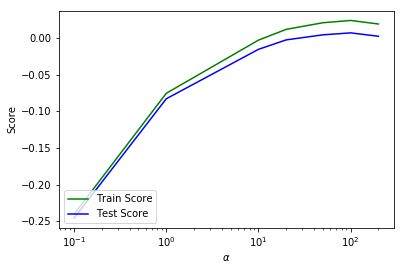

In [52]:
x_range=  [ 0.1, 1, 10, 20, 50, 100, 200]
plt.plot(x_range, linearSVM_regressor_train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_range, linearSVM_regressor_test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')
plt.ylabel('Score')

print(f'Best parameter for Linear SVM regression is: {linearSVM_regressor.best_params_}')
print(f'Average training score for Linear SVM regression model using 10Fold CV is: {((linearSVM_regressor.cv_results_["mean_train_score"]).sum())/len(x_range)}')
print(f'Average testing score for Linear SVM regression model using 10Fold CV is: {((linearSVM_regressor.cv_results_["mean_test_score"]).sum())/len(x_range)}')
      

In [53]:
#Implementing Linear SVM regression model using the best found parameters
linearSVM_final= LinearSVR(C= 50)
linearSVM_final.fit(x_train, y_train)
linearSVM_final_final_train_score= cross_val_score(linearSVM_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
linearSVM_final_final_test_score= cross_val_score(linearSVM_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Simple linearSVM regression model using 10 Fold CV is: {linearSVM_final_final_train_score.mean()}')
print(f'Test RMSE for best Simple linearSVM regression model using 10 Fold CV is: {linearSVM_final_final_test_score.mean()}')


Train RMSE for best Simple linearSVM regression model using 10 Fold CV is: -17410.706328408283
Test RMSE for best Simple linearSVM regression model using 10 Fold CV is: -19239.99273985449


In [54]:
compiled=compiled.append({'Regressor': 'linear_SVMRegression',
                          'Avg_Train_Score': ((linearSVM_regressor.cv_results_["mean_train_score"]).sum())/len(linearSVM_regressor_train_score_list), 
                          'Avg_Test_Score': ((linearSVM_regressor.cv_results_["mean_test_score"]).sum())/len(linearSVM_regressor_test_score_list),
                          'RMSE_Best_Param': linearSVM_final_final_train_score.mean(),
                          'Best_Hyperparameters': linearSVM_regressor.best_params_}, ignore_index=True)

2. Kernalized SVM Regression

In [67]:
#Creating hyperparameters for Grid Search
from sklearn.svm import SVR
parameters = [{'C':[ 0.1,1], 'kernel':['rbf','linear','poly'], 'gamma':[0.01,0.1]}]

SVM_regressor = GridSearchCV(estimator = SVR(), scoring= 'neg_mean_squared_error', param_grid = parameters, cv=5, n_jobs = -1)

SVM_regressor.fit(x_train,y_train)

#print("Grid search best score:", grid_search.best_score_)
#print("Grid search best parameters:", grid_search.best_params_)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 1], 'kernel': ['rbf', 'linear', 'poly'], 'gamma': [0.01, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [68]:
SVM_regressor.score(x_test, y_test)
SVM_regressor_train_score_list= SVM_regressor.cv_results_["mean_train_score"]
print(f'Train score across different params is: {SVM_regressor_train_score_list}')

SVM_regressor_test_score_list= SVM_regressor.cv_results_["mean_test_score"]
print(f'Train score across different params is: {SVM_regressor_test_score_list}')

Train score across different params is: [-20661.43255433 -19352.93855139 -20727.42842674 -20596.32556484
 -19352.93855139 -19277.86367828 -20095.70562016 -18327.84406672
 -20724.650836   -19736.77003993 -18327.84406672 -16507.8508528 ]
Train score across different params is: [-20684.77060845 -19416.97795094 -20756.69647111 -20629.55178835
 -19416.97795094 -19418.84753208 -20118.41451653 -18429.36373036
 -20760.87349257 -19835.62133114 -18429.36373036 -17077.57034534]


In [69]:
print(f'Best parameter for SVM regression is: {SVM_regressor.best_params_}')
print(f'Average training score for SVM regression model using 10Fold CV is: {(SVM_regressor_train_score_list.sum())/len(SVM_regressor_train_score_list)}')
print(f'Average testing score for SVM regression model using 10Fold CV is: {(SVM_regressor_test_score_list.sum())/len(SVM_regressor_test_score_list)}')

Best parameter for SVM regression is: {'C': 1, 'gamma': 0.1, 'kernel': 'poly'}
Average training score for SVM regression model using 10Fold CV is: -19474.132734109662
Average testing score for SVM regression model using 10Fold CV is: -19581.252454014048


In [70]:
#Implementing SVM Regressor model with the best estimator found from above analysis
svm_final= SVR(C=1 , gamma= 0.1 , kernel='poly')
svm_final.fit(x_train, y_train)
svm_final_train_scores=cross_val_score(svm_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
svm_final_test_scores=cross_val_score(svm_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best SVM regression model using 10 Fold CV is: {lasso_final_train_scores.mean()}')
print(f'Test  RMSE for best SVM regression model using 10 Fold CV is: {lasso_final_test_scores.mean()}')


Train RMSE for best SVM regression model using 10 Fold CV is: -14751.352578105802
Test  RMSE for best SVM regression model using 10 Fold CV is: -18405.348432579565


In [71]:
compiled=compiled.append({'Regressor': 'Kernel_SVMRegression',
                          'Avg_Train_Score': (SVM_regressor_train_score_list.sum())/len(SVM_regressor_train_score_list), 
                          'Avg_Test_Score':  (SVM_regressor_test_score_list.sum())/len(SVM_regressor_test_score_list),
                          'RMSE_Best_Param': lasso_final_test_scores.mean(),
                          'Best_Hyperparameters': SVM_regressor.best_params_}, ignore_index=True)

# KNN Regressor

In [55]:
knn= KNeighborsRegressor()
param= {'n_neighbors':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform','distance'],'algorithm':['auto','ball_tree','kd_tree','brute'] }
knn_regressor= GridSearchCV(knn, param, cv=10, return_train_score= True)
knn_regressor.fit(x_train, y_train)
knn_regressor.score(x_test, y_test)

0.5013430506656011

In [56]:
knn_regressor_train_score_list= knn_regressor.cv_results_["mean_train_score"]
print(f'Train score across different params is: {knn_regressor_train_score_list}')
knn_regressor_test_score_list= knn_regressor.cv_results_["mean_test_score"]
print(f'\nTest score across different params is: {knn_regressor_test_score_list}')

Train score across different params is: [1.         1.         0.79921309 1.         0.7040132  1.
 0.63219896 1.         0.59475584 1.         0.55284987 1.
 0.51561156 1.         0.48246056 1.         0.45590181 1.
 0.42708591 1.         1.         1.         0.79921309 1.
 0.7040132  1.         0.63219896 1.         0.59475584 1.
 0.55284987 1.         0.51561156 1.         0.48246056 1.
 0.45590181 1.         0.42708591 1.         1.         1.
 0.79921309 1.         0.7040132  1.         0.63219896 1.
 0.59475584 1.         0.55284987 1.         0.51561156 1.
 0.48246056 1.         0.45590181 1.         0.42708591 1.
 1.         1.         0.79921309 1.         0.7040132  1.
 0.63219896 1.         0.59475584 1.         0.55284987 1.
 0.51561156 1.         0.48246056 1.         0.45590181 1.
 0.42708591 1.        ]

Test score across different params is: [0.16700949 0.16700949 0.30135137 0.31832449 0.3311224  0.35924587
 0.35545932 0.38573997 0.36676282 0.39717217 0.35040926 0.3910

In [57]:
print(f'Best parameter for KNN regression is: {knn_regressor.best_params_}')
print(f'Average training score for KNN regression model using 10Fold CV is: {(knn_regressor_train_score_list.sum())/len(knn_regressor_train_score_list)}')
print(f'Average testing score for KNN regression model using 10Fold CV is: {(knn_regressor_test_score_list.sum())/len(knn_regressor_test_score_list)}')


Best parameter for KNN regression is: {'algorithm': 'brute', 'n_neighbors': 5, 'weights': 'distance'}
Average training score for KNN regression model using 10Fold CV is: 0.8082045402515915
Average testing score for KNN regression model using 10Fold CV is: 0.3221923453117007


In [58]:
#Implementing KNN Regressor model with the best estimator found from above analysis
KNN_final= KNeighborsRegressor(algorithm= 'auto', n_neighbors= 5, weights='distance')
KNN_final.fit(x_train, y_train)
KNN_final_train_scores=cross_val_score(KNN_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
KNN_final_test_scores=cross_val_score(KNN_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best KNN regression model using 10 Fold CV is: {KNN_final_train_scores.mean()}')
print(f'Test  RMSE for best KNN regression model using 10 Fold CV is: {KNN_final_test_scores.mean()}')


Train RMSE for best KNN regression model using 10 Fold CV is: -10363.515628892887
Test  RMSE for best KNN regression model using 10 Fold CV is: -16149.000312910392


In [59]:
compiled=compiled.append({'Regressor': 'KNN_Regression',
                          'Avg_Train_Score': (knn_regressor_train_score_list.sum())/len(knn_regressor_train_score_list), 
                          'Avg_Test_Score':  (knn_regressor_test_score_list.sum())/len(knn_regressor_test_score_list),
                          'RMSE_Best_Param': KNN_final_test_scores.mean(),
                          'Best_Hyperparameters': knn_regressor.best_params_}, ignore_index=True)

# Decision Tree Regressor

In [60]:
tree = DecisionTreeRegressor()
param_grid = [{'splitter': ['best', 'random'], 'max_depth': np.arange(5,15), 'max_features':[4,5,8,10]}]

tree_regressor= GridSearchCV(tree, param_grid, cv=5, return_train_score= True)              

In [61]:
tree_regressor.fit(x_train, y_train)
tree_regressor.score(x_test, y_test)

0.38361567049141165

In [62]:
tree_test_score_list= tree_regressor.cv_results_["mean_test_score"]
print(f'Test score across different alpha is: {tree_test_score_list}')
tree_train_score_list= tree_regressor.cv_results_["mean_train_score"]
print(f'\nTrain score across different alpha is: {tree_train_score_list}')


Test score across different alpha is: [ 0.00288374  0.11783402  0.01839236  0.07895654  0.12513272  0.10452675
  0.08409373  0.07772107  0.13259414  0.07794931  0.15049936  0.09429538
  0.09018134  0.1409256   0.14901107  0.11299395 -0.08060936  0.13718301
  0.19455962  0.1356184   0.14632508  0.10224825  0.17226044  0.12252717
  0.04197851  0.00096723  0.08239528  0.11319743  0.21061516  0.1068886
  0.11675574  0.17530735  0.15034616  0.14233135  0.2162688   0.08283126
  0.10920297  0.12719449  0.24921263 -0.08714019  0.21707586  0.09920838
  0.1974844   0.10789448  0.11230833  0.25922555  0.19455123  0.20647585
  0.29702014  0.09527493  0.20029824  0.22280683  0.07229681  0.20600854
  0.11024277  0.19403403  0.01266526 -0.00917411  0.06232599  0.15891756
  0.0622379  -0.04312745  0.11482607 -0.0548403   0.1530676   0.19205254
  0.15557445  0.19695601  0.02686982  0.10267209  0.07573881  0.17027273
  0.20088164  0.01662097  0.20996333 -0.0485657  -0.00601388  0.27807246
 -0.17346446 -

In [63]:
print(f'Best parameter for Decision tree regression is: {tree_regressor.best_params_}')
print(f'Average training score for KNN regression model using 10Fold CV is: {(tree_train_score_list.sum())/len(tree_train_score_list)}')
print(f'Average testing score for KNN regression model using 10Fold CV is: {(tree_test_score_list.sum())/len(tree_test_score_list)}')


Best parameter for Decision tree regression is: {'max_depth': 11, 'max_features': 4, 'splitter': 'best'}
Average training score for KNN regression model using 10Fold CV is: 0.6961121122254227
Average testing score for KNN regression model using 10Fold CV is: 0.11186316283455437


In [64]:
#Implementing Decision Tree Regressor model with the best estimator found from above analysis
tree_final= DecisionTreeRegressor(max_depth=8, max_features=5, splitter= 'random')
tree_final.fit(x_train, y_train)
tree_final_train_scores=cross_val_score(tree_final,x_train, y_train, cv=10, scoring= 'neg_mean_squared_error')
tree_final_test_scores=cross_val_score(tree_final,x_test, y_test, cv=10, scoring= 'neg_mean_squared_error')
print(f'Train RMSE for best Decision Tree regression model using 10 Fold CV is: {tree_final_train_scores.mean()}')
print(f'Test  RMSE for best Decision Tree regression model using 10 Fold CV is: {tree_final_test_scores.mean()}')


Train RMSE for best Decision Tree regression model using 10 Fold CV is: -14017.185165075594
Test  RMSE for best Decision Tree regression model using 10 Fold CV is: -28550.982996151834


In [65]:
compiled=compiled.append({'Regressor': 'Decision_Tree_Regression',
                          'Avg_Train_Score': (tree_train_score_list.sum())/len(tree_train_score_list), 
                          'Avg_Test_Score':  (tree_test_score_list.sum())/len(tree_test_score_list),
                          'RMSE_Best_Param': tree_final_test_scores.mean(),
                          'Best_Hyperparameters': tree_regressor.best_params_}, ignore_index=True)

# Comparing all the models best paramaters value

In [72]:
compiled

,Regressor,Avg_Train_Score,Avg_Test_Score,RMSE_Best_Param,Best_Hyperparameters
0,LinearRegression,0.136454,0.025437,-14773.423568,N/A
1,Ridge_Regression,0.216887,0.141268,-17989.595645,{'alpha': 20}
2,Lasso_Regression,0.203513,0.125541,-18405.348433,{'alpha': 0.1}
3,Polynomial_Regression,-1.128313,0.025437,-18524.502071,Degree:2
4,logistic_Regression,0.293363,0.245333,-13125.190566,"{'C': 1, 'penalty': 'l2'}"
5,linear_SVMRegression,-0.034923,-0.047730,-17410.706328,{'C': 100}
6,KNN_Regression,0.808205,0.322192,-16149.000313,"{'algorithm': 'brute', 'n_neighbors': 5, 'weig..."
7,Decision_Tree_Regression,0.696112,0.111863,-28550.982996,"{'max_depth': 11, 'max_features': 4, 'splitter..."
8,Kernel_SVMRegression,-19474.132734,-19581.252454,-18405.348433,"{'C': 1, 'gamma': 0.1, 'kernel': 'poly'}"
